In [3]:
import os
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, RandomFlip# type: ignore
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG19, VGG16

from sklearn.metrics import confusion_matrix

main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    path1 = os.path.join(main_path, direct)
    files = os.listdir(path1)
    if direct == "Normal":
        code = 0
        # code = [1,0]
    elif direct == "Tuberculosis":
        code = 1
        # code = [0,1]
    
    # counter = 0
    for file in files:
        # if counter < 4600:
        img = cv2.imread(os.path.join(path1,file))
        img = cv2.resize(img, (200,200))
        labels.append(code)
        images.append(img)
            # counter += 1


In [126]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(4200, 200, 200, 3)

'Label Shape'

(4200,)

In [127]:
data = images/255.0

In [128]:
X_train,X_test_combined, y_train, y_test_combined = train_test_split(data, labels, test_size=0.4, shuffle=True)


In [129]:
X_val, X_test, y_val, y_test = train_test_split(X_test_combined, y_test_combined, test_size=0.5, shuffle=True)

In [130]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(200, 200, 3))

In [131]:


x = base_model.output
# print(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation= 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [132]:
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [133]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [134]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 642s 8s/step - binary_accuracy: 0.8178 - loss: 0.9646 - val_binary_accuracy: 0.9857 - val_loss: 0.0471
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 611s 8s/step - binary_accuracy: 0.9798 - loss: 0.0598 - val_binary_accuracy: 0.9905 - val_loss: 0.0315
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 662s 8s/step - binary_accuracy: 0.9890 - loss: 0.0331 - val_binary_accuracy: 0.9905 - val_loss: 0.0236
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 502s 6s/step - binary_accuracy: 0.9881 - loss: 0.0322 - val_binary_accuracy: 0.9952 - val_loss: 0.0185
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 524s 7s/step - binary_accuracy: 0.9944 - loss: 0.0147 - val_binary_accuracy: 0.9952 - val_loss: 0.0164
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 506s 6s/step - binary_accuracy: 0.9986 - loss: 0.0076 - val_binary_accuracy: 0.9881 - val_loss: 0.0226
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 601s 8s/step - binary_accuracy: 0.9984 - loss: 0.0097 - val_binary_accuracy: 0.9929 - val_loss: 0.0229
Epoch 8/10
79

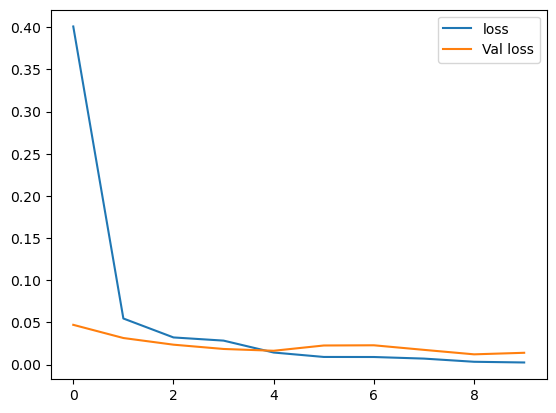

In [135]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

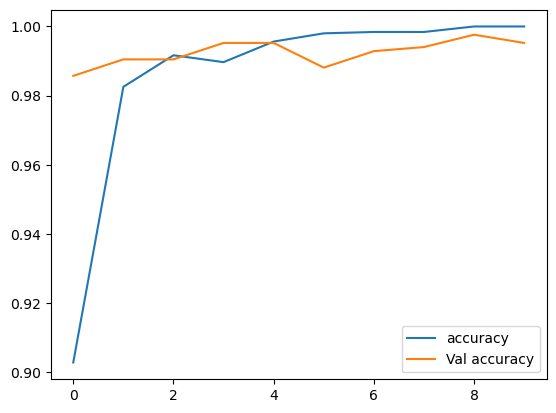

In [136]:
plt.plot(model.history.history['binary_accuracy'], label='accuracy')
plt.plot(model.history.history['val_binary_accuracy'], label='Val accuracy')
plt.legend()
plt.show()

In [137]:
result = model.evaluate(X_test, y_test, batch_size=32)


print(f'The accuracy is {result[1]}')
print(f'The loss is {result[0]}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - binary_accuracy: 0.9932 - loss: 0.0275
The accuracy is 0.9916666746139526
The loss is 0.032494157552719116


In [138]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step


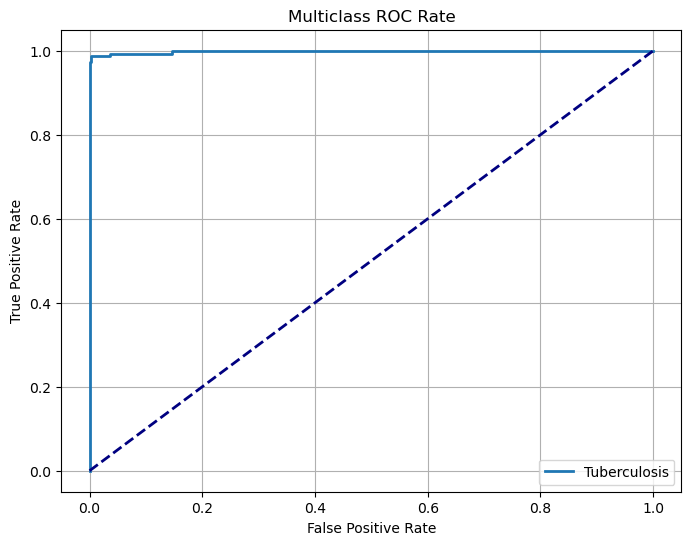

AUROC for class Tuberculosis : 0.999


In [139]:
y_true = y_test
n_classes = 2
fpr = {}
tpr = {}
# roc_auc = {}
classes_names = {0:"Normal", 1:"Tuberculosis"}
classes_names_list = ["Tuberculosis"]


fpr, tpr,  _ =  roc_curve(y_true, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))

plt.plot(
    fpr, tpr, 
    lw=2,
    label=f"Class {1} (area = {roc_auc:.3f})"
)

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(classes_names_list, loc="lower right")
plt.grid()
plt.show()


print(f"AUROC for class {classes_names[1]} : {roc_auc:.3f}")


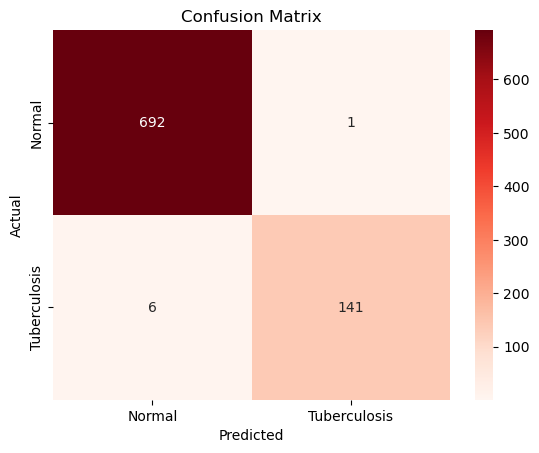

In [140]:
cm = confusion_matrix(y_true=y_true, y_pred=np.round(y_pred))

sns.heatmap(cm, cmap="Reds", 
            annot=True, 
            fmt='g',
            xticklabels=["Normal","Tuberculosis"],
            yticklabels=["Normal","Tuberculosis"],
            )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [141]:
print(f"Sensitivity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")
print(f"Specificity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")

Sensitivity to correctly classifiy a CXR with TB 0.959
Specificity to correctly classifiy a CXR with TB 0.993


In [142]:

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           25

 Total params: 34,181,701 (130.39 MB)

 Trainable params: 4,719,105 (18.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 9,438,212 (36.00 MB)

In [143]:
model.save("cxr_normal_tb_vgg16_model.keras")

In [4]:
from tensorflow.keras.models import load_model
model = load_model("cxr_normal_tb_vgg16_model.keras")

In [10]:

img_size  = (200, 200)
preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

classes_names = {0:"Normal", 1:"Tuberculosis"}

last_conv_layer_name = "block5_conv4"
file_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database\\Tuberculosis\\"
img_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database\\Tuberculosis\\Tuberculosis-56.png"

img = Image.open(img_path)
# img.show()

In [11]:
def decode_predictions(preds):
    return classes_names[round(preds[0][0])]


def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    print(model.output)
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output@pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)/tf.math.reduce_max(heatmap)

    return heatmap.numpy()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[0.980953]]
Predicted: Tuberculosis
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>


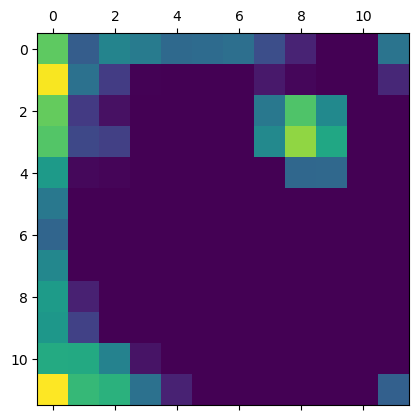

In [12]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# model.layers[-1].activation = None

preds = model.predict(img_array)
print(preds)
print("Predicted:", decode_predictions(preds))

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

In [13]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255*heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]

    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap*alpha+img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    new_img = Image.open(cam_path)
    new_img.show()

save_and_display_gradcam(img_path, heatmap)


In [ ]:
file_names_list = os.listdir(file_path)
random_sample = np.random.choice(len(file_names_list), 10)
print(random_sample)
for idx, file_name in enumerate(file_names_list):
    if idx in random_sample:
        current_file_path = os.path.join(file_path, file_name)
        img_array = preprocess_input(get_img_array(current_file_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        save_and_display_gradcam(current_file_path, heatmap)
        

[ 38 654 575 141 204 681 621 233 694 395]
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_95>


Next Steps
1. Train on more data
    - Use the MIMIC CXR to classify different pathologies
    - Use threading to Batch train whilst downloading CXR at the same time and delete files that have already been use for training
2. Augument the Data
3. Create a model that identifies if an image is a CXR before predicting if TB is present or not 
4. Send an Alert is TB is likely
5. Segment Abnormal area
6. Use a better CNN model